In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:

MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 296530923.88it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32757083.24it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 131410872.47it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20202045.35it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

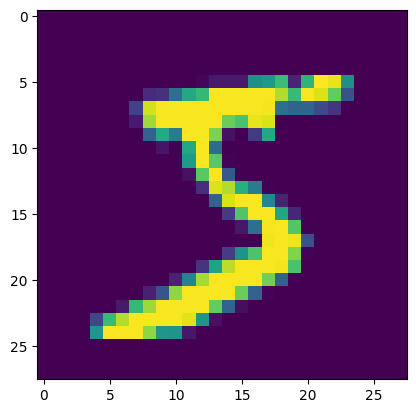

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

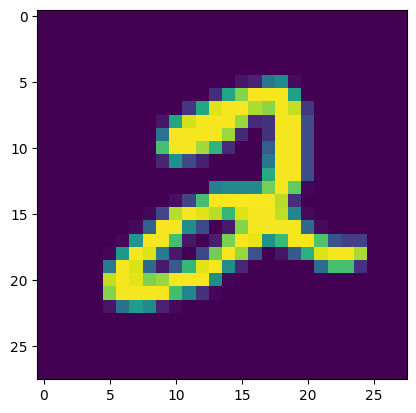

tensor(5)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[5, :, :])
plt.show()
print(y_train[0])

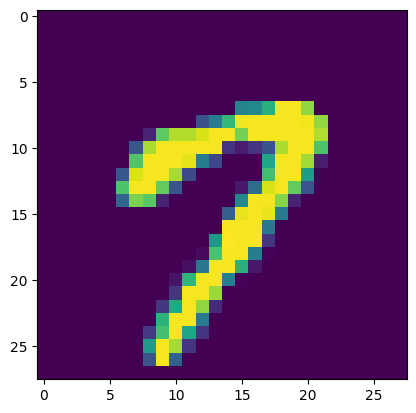

tensor(5)


In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[15, :, :])
plt.show()
print(y_train[0])

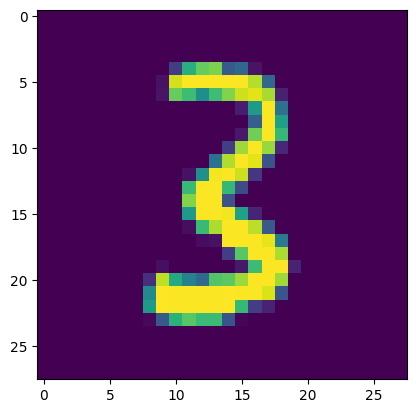

tensor(5)


In [19]:
import matplotlib.pyplot as plt
plt.imshow(X_train[50000, :, :])
plt.show()
print(y_train[0])

In [10]:
## Переводим в размер 60000*1*28*28*

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [13]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)## 14*14
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0) ## 14-4*14-4 == 10*10
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2) ## (10/2*10/2 = 5/5
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [15]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [16]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(5):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9742)
tensor(0.9839)
tensor(0.9848)
tensor(0.9884)
tensor(0.9883)


In [17]:
lenet5.forward(X_test)

tensor([[-1.3016, -0.0913,  0.6307,  ..., 11.6312, -1.1401,  2.2189],
        [ 0.2481,  1.1155, 11.1118,  ..., -3.3200,  2.2209, -3.3467],
        [-0.3477, 11.4222, -1.1670,  ...,  0.6732,  1.4041, -1.8578],
        ...,
        [-3.9071, -1.3189, -2.6614,  ...,  1.6610,  1.8675,  2.2193],
        [-1.3844, -2.9015, -5.1141,  ..., -5.7112,  2.3796,  0.4064],
        [ 1.1494, -3.0831, -0.6826,  ..., -7.1271, -0.1986, -2.5380]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

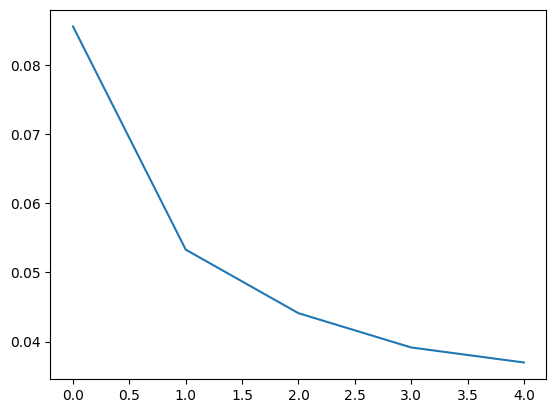

In [18]:
# plt.plot(test_accuracy_history);
plt.plot(test_loss_history);

## 2 вариант

In [22]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)## 14*14
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0) ## 14-4*14-4 == 10*10
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2) ## (10/2*10/2 = 5/5
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [24]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet5.parameters(), momentum=0.7, lr=0.01)

In [25]:
batch_size = 128

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9126)
tensor(0.9457)
tensor(0.9624)
tensor(0.9697)
tensor(0.9745)
tensor(0.9762)
tensor(0.9787)
tensor(0.9814)
tensor(0.9810)
tensor(0.9828)
tensor(0.9832)
tensor(0.9843)
tensor(0.9832)
tensor(0.9863)
tensor(0.9854)
tensor(0.9861)
tensor(0.9875)
tensor(0.9872)
tensor(0.9874)
tensor(0.9879)
tensor(0.9872)
tensor(0.9897)
tensor(0.9882)
tensor(0.9885)
tensor(0.9889)
tensor(0.9882)
tensor(0.9888)
tensor(0.9893)
tensor(0.9894)
tensor(0.9898)
tensor(0.9889)
tensor(0.9886)
tensor(0.9899)
tensor(0.9892)
tensor(0.9899)
tensor(0.9899)
tensor(0.9903)
tensor(0.9907)
tensor(0.9910)
tensor(0.9907)
tensor(0.9903)
tensor(0.9901)
tensor(0.9907)
tensor(0.9908)
tensor(0.9911)
tensor(0.9916)
tensor(0.9905)
tensor(0.9905)
tensor(0.9906)
tensor(0.9907)
tensor(0.9919)
tensor(0.9908)
tensor(0.9894)
tensor(0.9922)
tensor(0.9917)
tensor(0.9910)
tensor(0.9912)
tensor(0.9907)
tensor(0.9909)
tensor(0.9910)
tensor(0.9912)
tensor(0.9908)
tensor(0.9913)
tensor(0.9907)
tensor(0.9911)
tensor(0.9913)
tensor(0.9

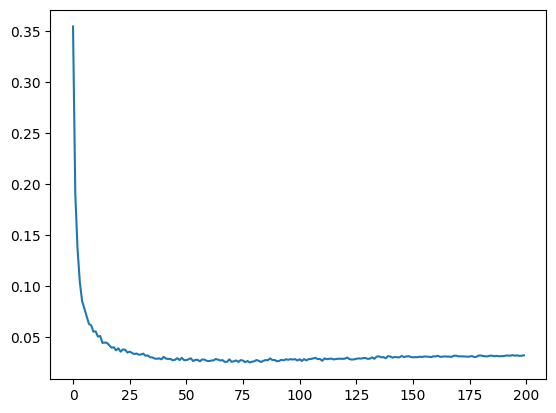

In [26]:
plt.plot(test_loss_history);

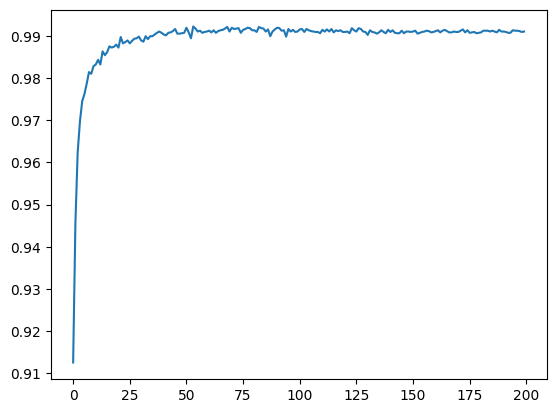

In [27]:
plt.plot(test_accuracy_history);

In [28]:
print(max(test_accuracy_history))

tensor(0.9922)


In [ ]:
## Вариант 3

In [37]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)## 14*14
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0) ## 14-4*14-4 == 10*10
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) ## (10/2*10/2 = 5/5
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [39]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)


In [40]:
batch_size = 128

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9797)
tensor(0.9807)
tensor(0.9872)
tensor(0.9856)
tensor(0.9847)
tensor(0.9865)
tensor(0.9865)
tensor(0.9876)
tensor(0.9879)
tensor(0.9866)
tensor(0.9861)
tensor(0.9855)
tensor(0.9843)
tensor(0.9862)
tensor(0.9864)
tensor(0.9890)
tensor(0.9889)
tensor(0.9892)
tensor(0.9865)
tensor(0.9868)
tensor(0.9856)
tensor(0.9834)
tensor(0.9867)
tensor(0.9866)
tensor(0.9882)
tensor(0.9865)
tensor(0.9888)
tensor(0.9860)
tensor(0.9860)
tensor(0.9865)
tensor(0.9848)
tensor(0.9849)
tensor(0.9871)
tensor(0.9889)
tensor(0.9872)
tensor(0.9889)
tensor(0.9891)
tensor(0.9893)
tensor(0.9897)
tensor(0.9894)
tensor(0.9888)
tensor(0.9890)
tensor(0.9852)
tensor(0.9844)
tensor(0.9896)
tensor(0.9880)
tensor(0.9890)
tensor(0.9897)
tensor(0.9877)
tensor(0.9900)
tensor(0.9884)
tensor(0.9874)
tensor(0.9888)
tensor(0.9895)
tensor(0.9890)
tensor(0.9898)
tensor(0.9891)
tensor(0.9885)
tensor(0.9867)
tensor(0.9889)
tensor(0.9868)
tensor(0.9873)
tensor(0.9877)
tensor(0.9892)
tensor(0.9875)
tensor(0.9894)
tensor(0.9

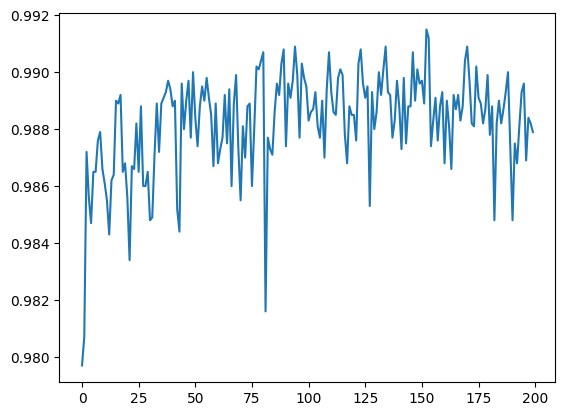

In [41]:
plt.plot(test_accuracy_history);

In [42]:
print(max(test_accuracy_history))

tensor(0.9915)


In [ ]:
## Вариант 4

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)## 14*14
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0) ## 14-4*14-4 == 10*10
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) ## (10/2*10/2 = 5/5
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [10]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet5.parameters(), momentum=0.7, lr=0.001)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [13]:
batch_size = 128

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9538)
tensor(0.9698)
tensor(0.9745)
tensor(0.9825)
tensor(0.9802)
tensor(0.9805)
tensor(0.9844)
tensor(0.9855)
tensor(0.9831)
tensor(0.9826)
tensor(0.9859)
tensor(0.9883)
tensor(0.9799)
tensor(0.9868)
tensor(0.9866)
tensor(0.9869)
tensor(0.9866)
tensor(0.9869)
tensor(0.9867)
tensor(0.9884)
tensor(0.9875)
tensor(0.9871)
tensor(0.9861)
tensor(0.9871)
tensor(0.9864)
tensor(0.9853)
tensor(0.9871)
tensor(0.9870)
tensor(0.9881)
tensor(0.9872)
tensor(0.9884)
tensor(0.9881)
tensor(0.9889)
tensor(0.9887)
tensor(0.9882)
tensor(0.9884)
tensor(0.9892)
tensor(0.9887)
tensor(0.9878)
tensor(0.9884)
tensor(0.9884)
tensor(0.9886)
tensor(0.9895)
tensor(0.9892)
tensor(0.9883)
tensor(0.9889)
tensor(0.9892)
tensor(0.9895)
tensor(0.9896)
tensor(0.9897)
tensor(0.9890)
tensor(0.9895)
tensor(0.9886)
tensor(0.9893)
tensor(0.9892)
tensor(0.9890)
tensor(0.9901)
tensor(0.9890)
tensor(0.9888)
tensor(0.9897)
tensor(0.9889)
tensor(0.9897)
tensor(0.9890)
tensor(0.9893)
tensor(0.9894)
tensor(0.9894)
tensor(0.9

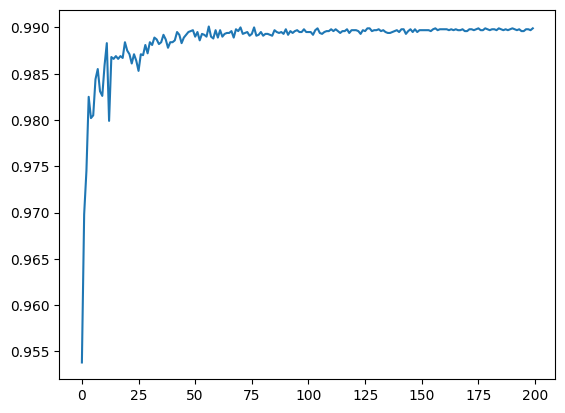

In [14]:
plt.plot(test_accuracy_history);

In [15]:
print(max(test_accuracy_history))

tensor(0.9901)
